# NB - Tiktok

In [1]:
import sys
import os
import pandas as pd

# Agregar el directorio raiz al PYTHONPATH
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

Importar modelo NB y cargar datos

In [2]:
from src.trainers.train_nb import train_nb
from src.trainers.utils import evaluate_model
from src.trainers.utils import save_model, load_model
from src.trainers.utils import build_datasets, save_metrics
from constants.constants_tiktok import NB_TFIDF_PIPELINE_PATH, NB_BOW_PIPELINE_PATH
from constants.constants_tiktok import TIKTOK_DATASET_SENTENCES, TIKTOK_NB_METRICS_PATH

dataset_train, dataset_test, dataset_val = build_datasets(
    TIKTOK_DATASET_SENTENCES,
    test_size=0.3,
    val_size=0.5, # 0.5 de 0.3    
    random_state=42
)
print(dataset_train.shape)
print(dataset_test.shape)
print(dataset_val.shape)

(13727, 2)
(2942, 2)
(2942, 2)


## NB + TFIDF

Accuracy: 0.67675050985724

Reporte de clasificacion
              precision    recall  f1-score   support

           0       0.68      0.73      0.70       980
           1       0.66      0.45      0.54       981
           2       0.68      0.85      0.76       981

    accuracy                           0.68      2942
   macro avg       0.67      0.68      0.67      2942
weighted avg       0.67      0.68      0.67      2942

Matriz de confusión
Modelo guardado en: c:\Users\Diego\Desktop\sentiment_analysis\models\tiktok\nb\nb_tfidf_pipeline.pkl


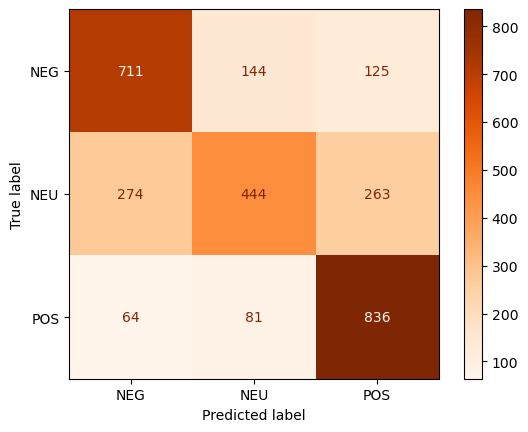

In [14]:
pipeline, metrics = train_nb(
    dataset_train,
    dataset_val,
    alpha=2.8,
    vec="tfidf"
)
# Guardar Pipeline
save_model(pipeline, NB_TFIDF_PIPELINE_PATH)
save_metrics(metrics, TIKTOK_NB_METRICS_PATH)

In [8]:
from constants.constants_nlp import INDEX_TO_POLARITY
from src.preprocesamiento.clean import clean_text
from src.preprocesamiento.nlp_spacy import preprocesamiento

textos_test = ["Hola! cómo estás???😀","el dia de hoy estoy feliz y contento", "estoy muy triste", "Me encuentro estudiando para un exámen", "A veces me encuentro triste, pero la mayoria del tiempo estoy muy feliz"]
textos_test = list(map(lambda x: clean_text(x), textos_test))
textos_test = preprocesamiento(textos_test)

preds = pipeline.predict(textos_test)
for input, pred in zip(textos_test,preds):
    print(f"{input}: {INDEX_TO_POLARITY[pred]}")

Modelo cargado: es_core_news_sm


100%|██████████| 5/5 [00:00<00:00, 1658.75it/s]
5it [00:00, 384.23it/s]

Aplicando stemming...
Total de documentos preprocesados: 5
hol estar: NEU
feliz content: POS
trist: NEG
encontr estudi exam: NEU
encontr trist mayor tiemp feliz: POS


### Evaluación

Cargando modelo: c:\Users\Diego\Desktop\sentiment_analysis\models\tiktok\nb\nb_tfidf_pipeline.pkl
Accuracy: 0.6631543167912984

Reporte de clasificacion
              precision    recall  f1-score   support

           0       0.66      0.71      0.68       981
           1       0.64      0.44      0.52       980
           2       0.68      0.85      0.75       981

    accuracy                           0.66      2942
   macro avg       0.66      0.66      0.65      2942
weighted avg       0.66      0.66      0.65      2942

Matriz de confusión


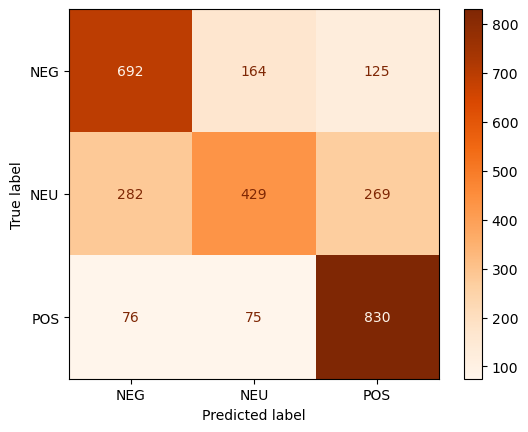

In [15]:
from constants.constants_tiktok import NB_TFIDF_PIPELINE_PATH

pipeline = load_model(NB_TFIDF_PIPELINE_PATH)
metrics = evaluate_model(pipeline, dataset_test)

## NB + BOW

Accuracy: 0.6624745071380014

Reporte de clasificacion
              precision    recall  f1-score   support

           0       0.65      0.72      0.69       980
           1       0.64      0.44      0.52       981
           2       0.68      0.83      0.75       981

    accuracy                           0.66      2942
   macro avg       0.66      0.66      0.65      2942
weighted avg       0.66      0.66      0.65      2942

Matriz de confusión
Modelo guardado en: c:\Users\Diego\Desktop\sentiment_analysis\models\tiktok\nb\nb_bow_pipeline.pkl


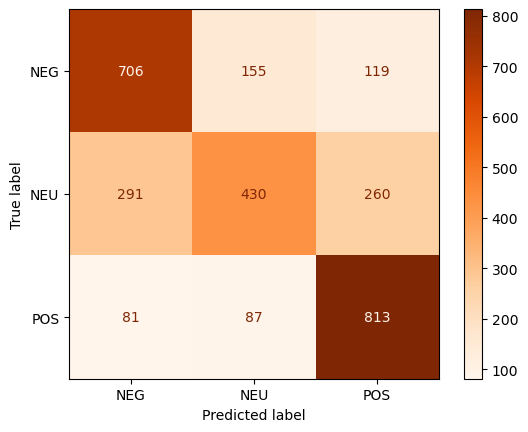

In [23]:
pipeline, metrics = train_nb(
    dataset_train,
    dataset_val,
    alpha=2.8,
    vec="bow"
)
# Guardar Pipeline
save_model(pipeline, NB_BOW_PIPELINE_PATH)
save_metrics(metrics, TIKTOK_NB_METRICS_PATH)

### Evaluación

Cargando modelo: c:\Users\Diego\Desktop\sentiment_analysis\models\tiktok\nb\nb_bow_pipeline.pkl
Accuracy: 0.6638341264445955

Reporte de clasificacion
              precision    recall  f1-score   support

           0       0.65      0.73      0.68       981
           1       0.64      0.42      0.51       980
           2       0.69      0.84      0.76       981

    accuracy                           0.66      2942
   macro avg       0.66      0.66      0.65      2942
weighted avg       0.66      0.66      0.65      2942

Matriz de confusión


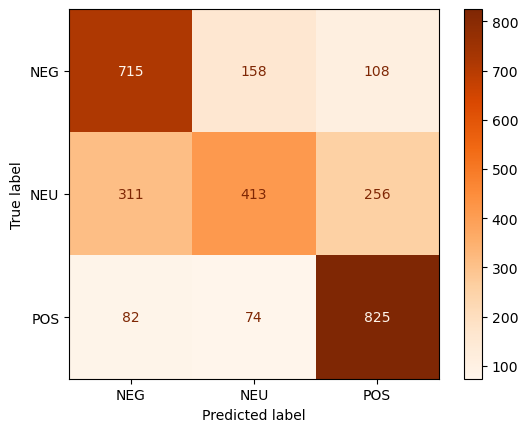

In [24]:
from constants.constants_tiktok import NB_BOW_PIPELINE_PATH

pipeline = load_model(NB_BOW_PIPELINE_PATH)
metrics = evaluate_model(pipeline, dataset_test)